#Importing necessary libraries

In [ ]:
!pip install opendatasets
!pip install gradio

import os
import glob
import random
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, util, color
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model, Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ProgbarLogger
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.datasets import mnist
from keras.applications import ResNet50
from keras.utils import plot_model

import opendatasets as od
import gradio as gr

!pip install --upgrade tensorflow
!pip install --upgrade gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.


#Dataset
Use datasets from the kaggle.

In [ ]:
dataset_url = 'kaggle.com/datasets/pmigdal/alien-vs-predator-images/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: michalakk
Your Kaggle Key: ··········


100%|██████████| 14.1M/14.1M [00:01<00:00, 7.83MB/s]


In [ ]:
train_path = '/content/alien-vs-predator-images/data/train'
valid_path = '/content/alien-vs-predator-images/data/validation'

In [ ]:
class_names = sorted(os.listdir(train_path))

class_counts = {}

for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    file_count = len(os.listdir(class_dir))
    class_counts[class_name] = file_count

for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


alien: 347
predator: 347


##Check the quality of the data

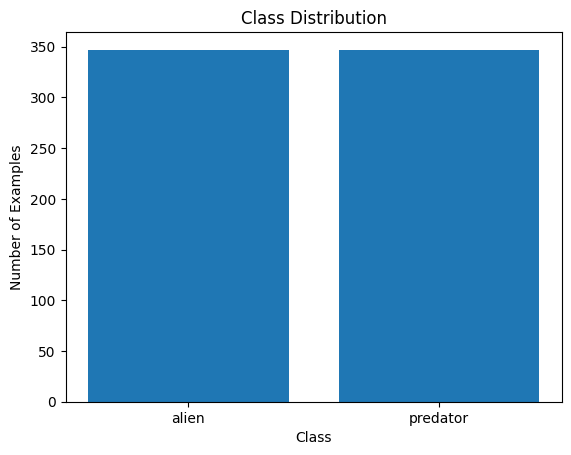

In [ ]:
class_counts = []

for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    file_count = len(os.listdir(class_dir))
    class_counts.append(file_count)

plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.title('Class Distribution')
plt.show()


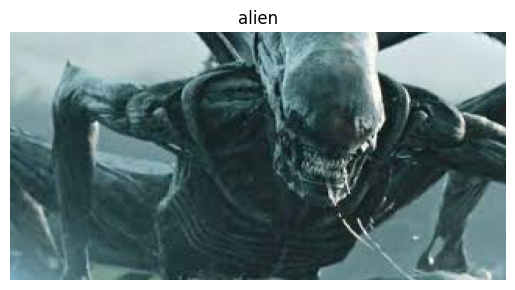

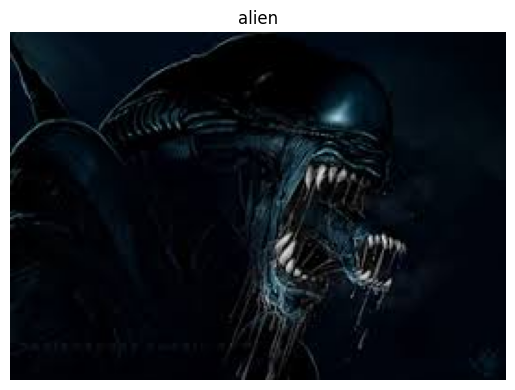

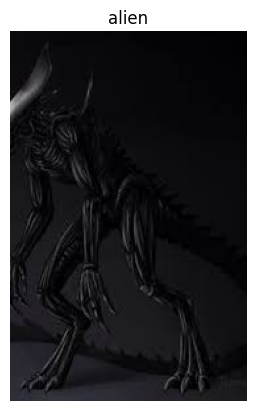

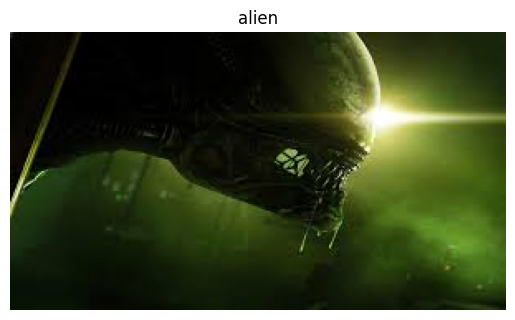

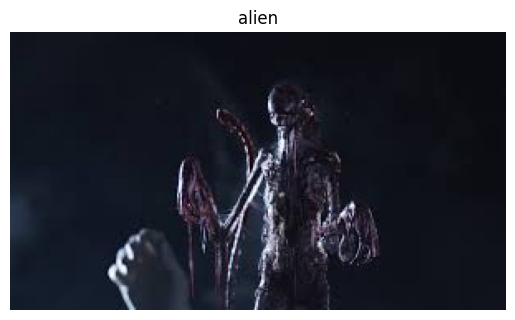

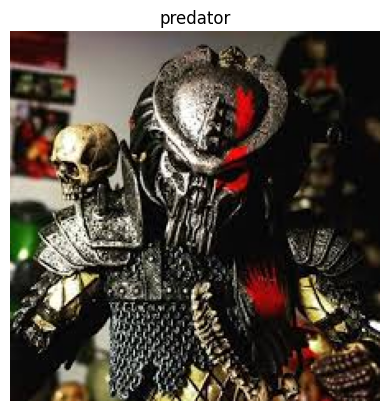

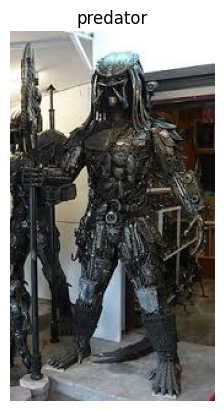

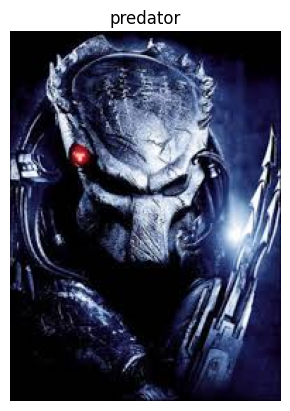

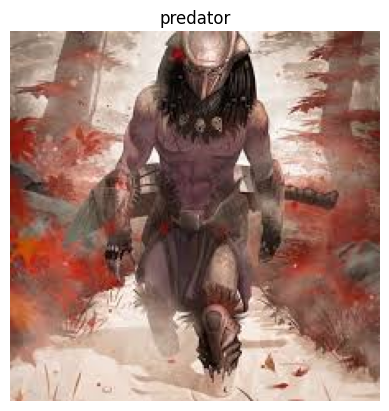

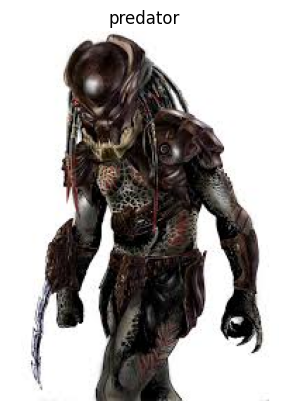

In [ ]:
num_examples = 5
random.seed(42)

for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    file_names = os.listdir(class_dir)
    random_files = random.sample(file_names, num_examples)

    for file_name in random_files:
        image_path = os.path.join(class_dir, file_name)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
        plt.show()


##Data preprocessing

In [ ]:
train_files = os.listdir(train_path)
train, test = train_test_split(train_files, test_size=0.2, random_state=42)

valid_files = os.listdir(valid_path)
valid, test = train_test_split(valid_files, test_size=0.5, random_state=42)

##Model definition, training, and evaluation

In [ ]:
batch_size = 32
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
train_data = train_generator.flow_from_directory(
    train_path,
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
valid_data = valid_generator.flow_from_directory(
    valid_path,
    target_size=(128, 128),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


###grayscale

In [ ]:
target_size = (224, 224,)
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    )

train_gray = train_generator.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='grayscale'
)


valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    )


valid_gray = valid_datagen.flow_from_directory(
    valid_path,
    batch_size=batch_size,
    target_size = target_size,
    class_mode='categorical',
    color_mode='grayscale'
    )



Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
train_gray[0][0].shape

(32, 224, 224, 1)

In [ ]:
batch_size = 32
epochs = 10
num_classes = 2

In [ ]:
input_shape = (224, 224, 1)

model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history_gray = model.fit(
    train_gray,
    steps_per_epoch=train_gray.samples // batch_size,
    epochs=epochs,
    validation_data=valid_gray,
    validation_steps=valid_gray.samples // batch_size)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dropout (Dropout)           (None, 186624)            0

Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c855072e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c855072e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <bound method _BaseOptimizer._update_step_xla of <tensorflow.python.eager.polymorphic_function.tracing_compiler.TfMethodTarget object at 0x7c2c18129510>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <bound method _BaseOptimizer._update_step_xla of <tensorflow.python.eager.polymorphic_function.tracing_compiler.TfMethodTarget object at 0x7c2c18129510>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - ETA: 0s - loss: 0.8195 - accuracy: 0.4924

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c49667d90>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c49667d90>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - 17s 205ms/step - loss: 0.8195 - accuracy: 0.4924 - val_loss: 0.6917 - val_accuracy: 0.5833
Epoch 2/10
21/21 [==============================] - 2s 92ms/step - loss: 0.6755 - accuracy: 0.6435 - val_loss: 0.6625 - val_accuracy: 0.6146
Epoch 3/10
21/21 [==============================] - 2s 103ms/step - loss: 0.5983 - accuracy: 0.6828 - val_loss: 0.6320 - val_accuracy: 0.6250
Epoch 4/10
21/21 [===========

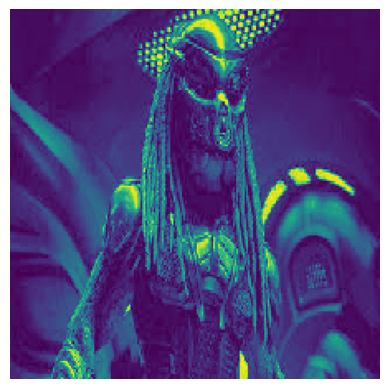

In [ ]:
augmented_images, _ = train_gray.next()

augmented_image = augmented_images[0]

plt.imshow(augmented_image)
plt.axis('off')
plt.show()


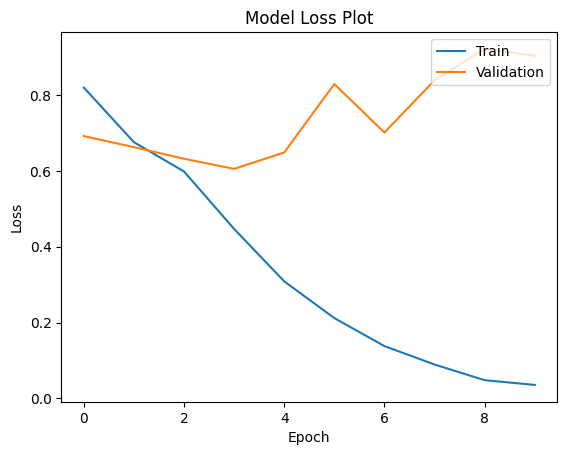

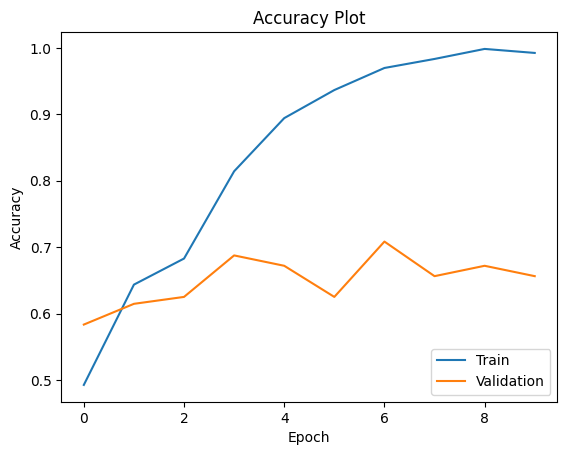

In [ ]:
plt.plot(history_gray.history['loss'])
plt.plot(history_gray.history['val_loss'])
plt.title('Model Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history_gray.history['accuracy'])
plt.plot(history_gray.history['val_accuracy'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

###rgb

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
)

train_rgb = train_datagen.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='rgb'
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
)

valid_rgb = valid_datagen.flow_from_directory(
    valid_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='rgb'
)

batch_size = 32
epochs = 10
num_classes = 2
input_shape = (224, 224, 3)

model_2 = keras.Sequential()
model_2.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(num_classes, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

history_rgb = model_2.fit(
    train_rgb,
    steps_per_epoch=train_rgb.samples // batch_size,
    epochs=epochs,
    validation_data=valid_rgb,
    validation_steps=valid_rgb.samples // batch_size
)


Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                      

Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c0437e320>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c0437e320>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - ETA: 0s - loss: 0.8748 - accuracy: 0.5544

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c095d0d30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c095d0d30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - 4s 128ms/step - loss: 0.8748 - accuracy: 0.5544 - val_loss: 0.6587 - val_accuracy: 0.5104
Epoch 2/10
21/21 [==============================] - 2s 84ms/step - loss: 0.5929 - accuracy: 0.7069 - val_loss: 0.6652 - val_accuracy: 0.6406
Epoch 3/10
21/21 [==============================] - 2s 77ms/step - loss: 0.5119 - accuracy: 0.7810 - val_loss: 0.5920 - val_accuracy: 0.6771
Epoch 4/10
21/21 [=============

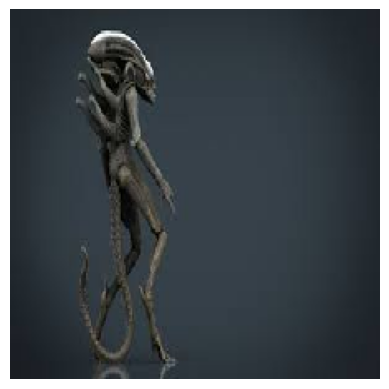

In [ ]:
augmented_images, _ = train_rgb.next()


augmented_image = augmented_images[0]

plt.imshow(augmented_image)
plt.axis('off')
plt.show()


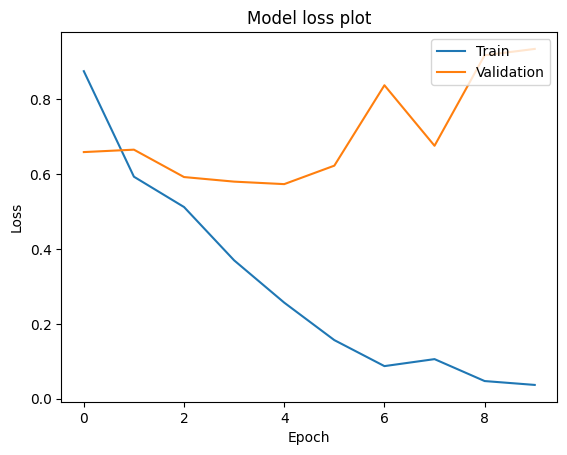

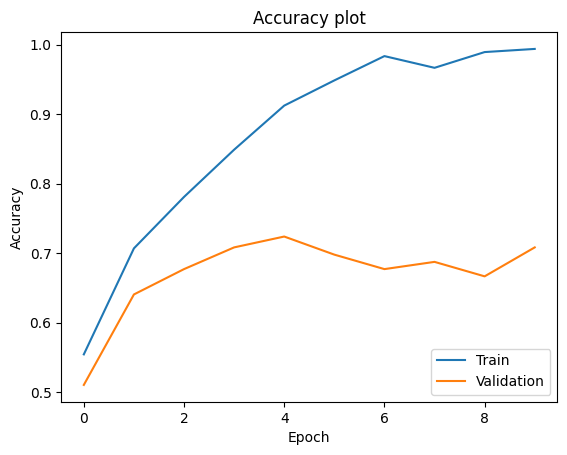

In [ ]:
plt.plot(history_rgb.history['loss'])
plt.plot(history_rgb.history['val_loss'])
plt.title('Model loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history_rgb.history['accuracy'])
plt.plot(history_rgb.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

###rotate

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    fill_mode='nearest'
)

train_rot = train_datagen.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='rgb'
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

valid_rot = valid_datagen.flow_from_directory(
    valid_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='rgb'
)

batch_size = 32
epochs = 10
num_classes = 2
input_shape = (224, 224, 3)

model_3 = keras.Sequential()
model_3.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_3.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(num_classes, activation='softmax'))

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_3.summary()

history_rot = model_3.fit(
    train_rot,
    steps_per_epoch=train_rot.samples // batch_size,
    epochs=epochs,
    validation_data=valid_rot,
    validation_steps=valid_rot.samples // batch_size
)


Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                      

Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c00238550>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c00238550>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - ETA: 0s - loss: 0.8250 - accuracy: 0.5559

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c002ba560>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c002ba560>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - 10s 433ms/step - loss: 0.8250 - accuracy: 0.5559 - val_loss: 0.6561 - val_accuracy: 0.6198
Epoch 2/10
21/21 [==============================] - 8s 379ms/step - loss: 0.6275 - accuracy: 0.6616 - val_loss: 0.6524 - val_accuracy: 0.6146
Epoch 3/10
21/21 [==============================] - 10s 472ms/step - loss: 0.5874 - accuracy: 0.6813 - val_loss: 0.6285 - val_accuracy: 0.6198
Epoch 4/10
21/21 [=========

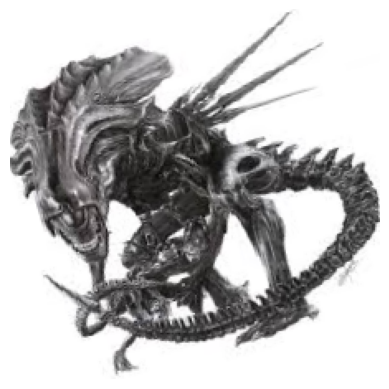

In [ ]:
augmented_images, _ = train_rot.next()
augmented_image = augmented_images[0]

plt.imshow(augmented_image)
plt.axis('off')
plt.show()

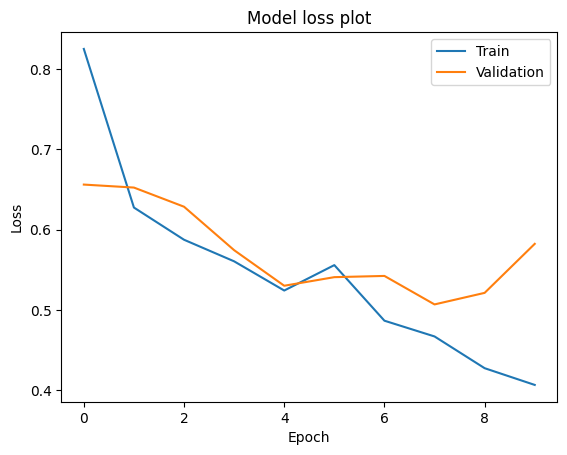

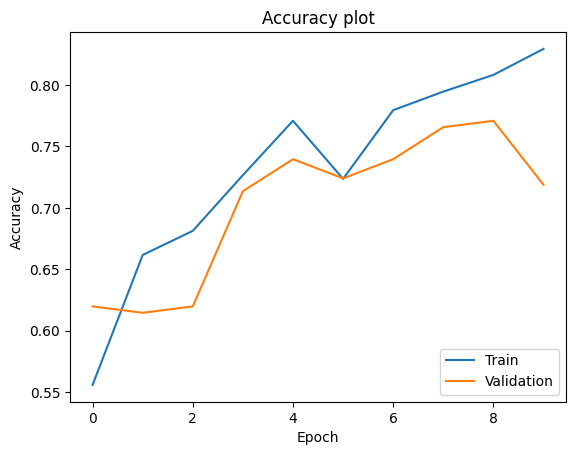

In [ ]:
plt.plot(history_rot.history['loss'])
plt.plot(history_rot.history['val_loss'])
plt.title('Model loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history_rot.history['accuracy'])
plt.plot(history_rot.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

###flip

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    vertical_flip=True,
)

train_flip = train_datagen.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='rgb'
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

valid_flip = valid_datagen.flow_from_directory(
    valid_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='rgb'
)

batch_size = 32
epochs = 10
num_classes = 2
input_shape = (224, 224, 3)

model_4 = keras.Sequential()
model_4.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_4.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_4.add(layers.Flatten())
model_4.add(layers.Dropout(0.5))
model_4.add(layers.Dense(num_classes, activation='softmax'))

model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_4.summary()

history_flip = model_4.fit(
    train_flip,
    steps_per_epoch=train_flip.samples // batch_size,
    epochs=epochs,
    validation_data=valid_flip,
    validation_steps=valid_flip.samples // batch_size
)


Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 186624)            0         
                                      

Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c0023b9a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c0023b9a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/21 [===========================>..] - ETA: 0s - loss: 0.9401 - accuracy: 0.5219

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c043e1240>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c043e1240>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - 3s 89ms/step - loss: 0.9301 - accuracy: 0.5227 - val_loss: 0.6553 - val_accuracy: 0.5885
Epoch 2/10
21/21 [==============================] - 2s 90ms/step - loss: 0.6021 - accuracy: 0.6692 - val_loss: 0.6115 - val_accuracy: 0.6458
Epoch 3/10
21/21 [==============================] - 2s 114ms/step - loss: 0.5471 - accuracy: 0.7523 - val_loss: 0.5915 - val_accuracy: 0.7083
Epoch 4/10
21/21 [=============

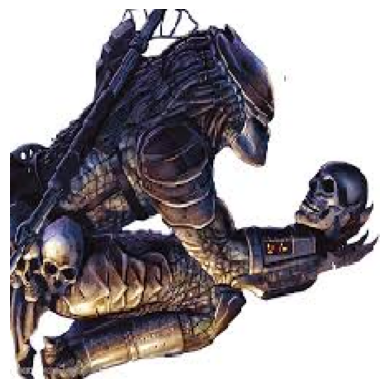

In [ ]:
augmented_images, _ = train_flip.next()
augmented_image = augmented_images[0]

plt.imshow(augmented_image)
plt.axis('off')
plt.show()

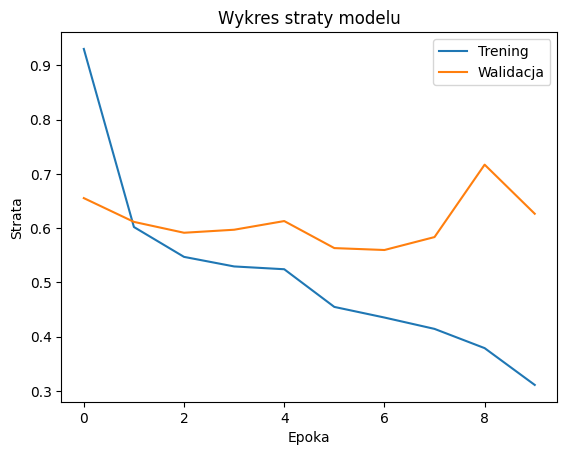

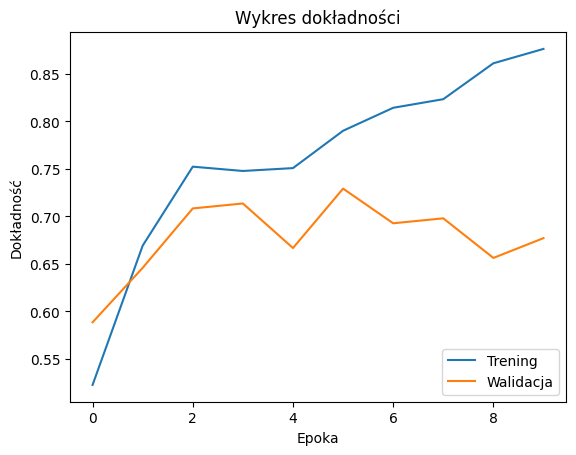

In [ ]:
plt.plot(history_flip.history['loss'])
plt.plot(history_flip.history['val_loss'])
plt.title('Wykres straty modelu')
plt.ylabel('Strata')
plt.xlabel('Epoka')
plt.legend(['Trening', 'Walidacja'], loc='upper right')
plt.show()

plt.plot(history_flip.history['accuracy'])
plt.plot(history_flip.history['val_accuracy'])
plt.title('Wykres dokładności')
plt.ylabel('Dokładność')
plt.xlabel('Epoka')
plt.legend(['Trening', 'Walidacja'], loc='lower right')
plt.show()


###brightness

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    brightness_range=[0.5,2.0]
)

train_bright = train_datagen.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='rgb'
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

valid_bright = valid_datagen.flow_from_directory(
    valid_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='rgb'
)

batch_size = 32
epochs = 10
num_classes = 2
input_shape = (224, 224, 3)

model_5 = keras.Sequential()
model_5.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_5.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_5.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_5.add(layers.Flatten())
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(num_classes, activation='softmax'))

model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_5.summary()

history_bright = model_5.fit(
    train_bright,
    steps_per_epoch=train_bright.samples // batch_size,
    epochs=epochs,
    validation_data=valid_bright,
    validation_steps=valid_bright.samples // batch_size
)


Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 186624)            0         
                                      

Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c002a2f80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c002a2f80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - ETA: 0s - loss: 1.1265 - accuracy: 0.5242

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c854645e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c854645e0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - 4s 126ms/step - loss: 1.1265 - accuracy: 0.5242 - val_loss: 0.6564 - val_accuracy: 0.5156
Epoch 2/10
21/21 [==============================] - 2s 115ms/step - loss: 0.5982 - accuracy: 0.6239 - val_loss: 0.6345 - val_accuracy: 0.6562
Epoch 3/10
21/21 [==============================] - 2s 103ms/step - loss: 0.5168 - accuracy: 0.7644 - val_loss: 0.5744 - val_accuracy: 0.6979
Epoch 4/10
21/21 [===========

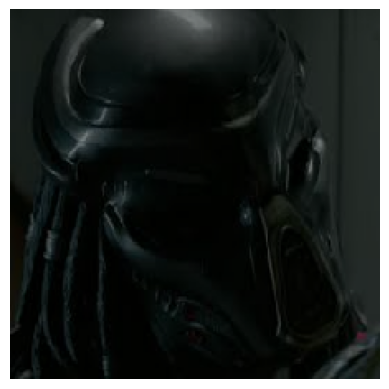

In [ ]:
augmented_images, _ = train_bright.next()
augmented_image = augmented_images[0]

plt.imshow(augmented_image)
plt.axis('off')
plt.show()

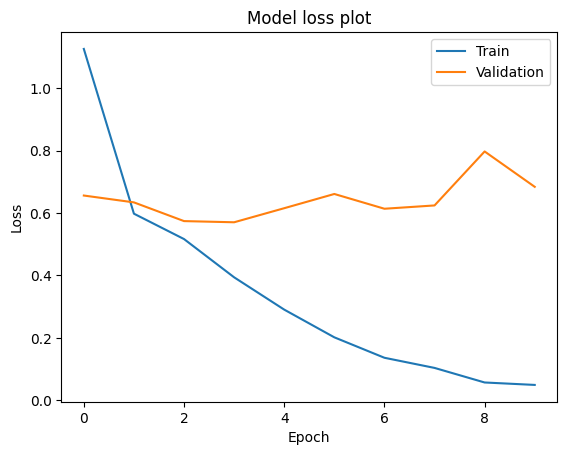

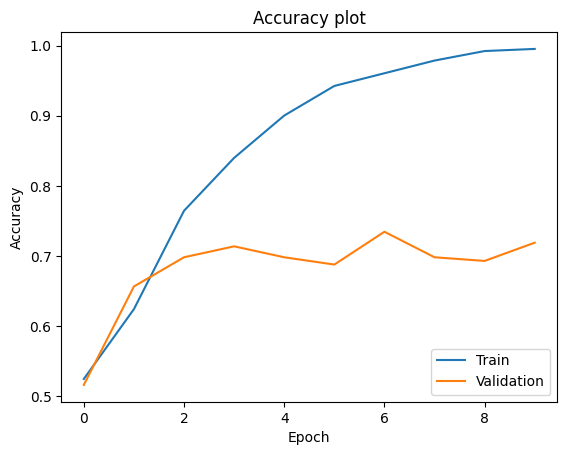

In [ ]:
plt.plot(history_bright.history['loss'])
plt.plot(history_bright.history['val_loss'])
plt.title('Model loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history_bright.history['accuracy'])
plt.plot(history_bright.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

###ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(num_classes, activation='softmax')(x)
model_6 = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = False

model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_6.summary()

history_RN50 = model_6.fit(
    train_rgb,
    steps_per_epoch=train_rgb.samples // batch_size,
    epochs=epochs,
    validation_data=valid_rgb,
    validation_steps=valid_rgb.samples // batch_size
)


94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c857ca8c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7c2c857ca8c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - ETA: 0s - loss: 0.7304 - accuracy: 0.5151

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c855e9120>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7c2c855e9120>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
21/21 [==============================] - 10s 230ms/step - loss: 0.7304 - accuracy: 0.5151 - val_loss: 0.6804 - val_accuracy: 0.4948
Epoch 2/10
21/21 [==============================] - 3s 167ms/step - loss: 0.6721 - accuracy: 0.5680 - val_loss: 0.6636 - val_accuracy: 0.5104
Epoch 3/10
21/21 [==============================] - 3s 166ms/step - loss: 0.6558 - accuracy: 0.5785 - val_loss: 0.6390 - val_accuracy: 0.6562
Epoch 4/10
21/21 [==========

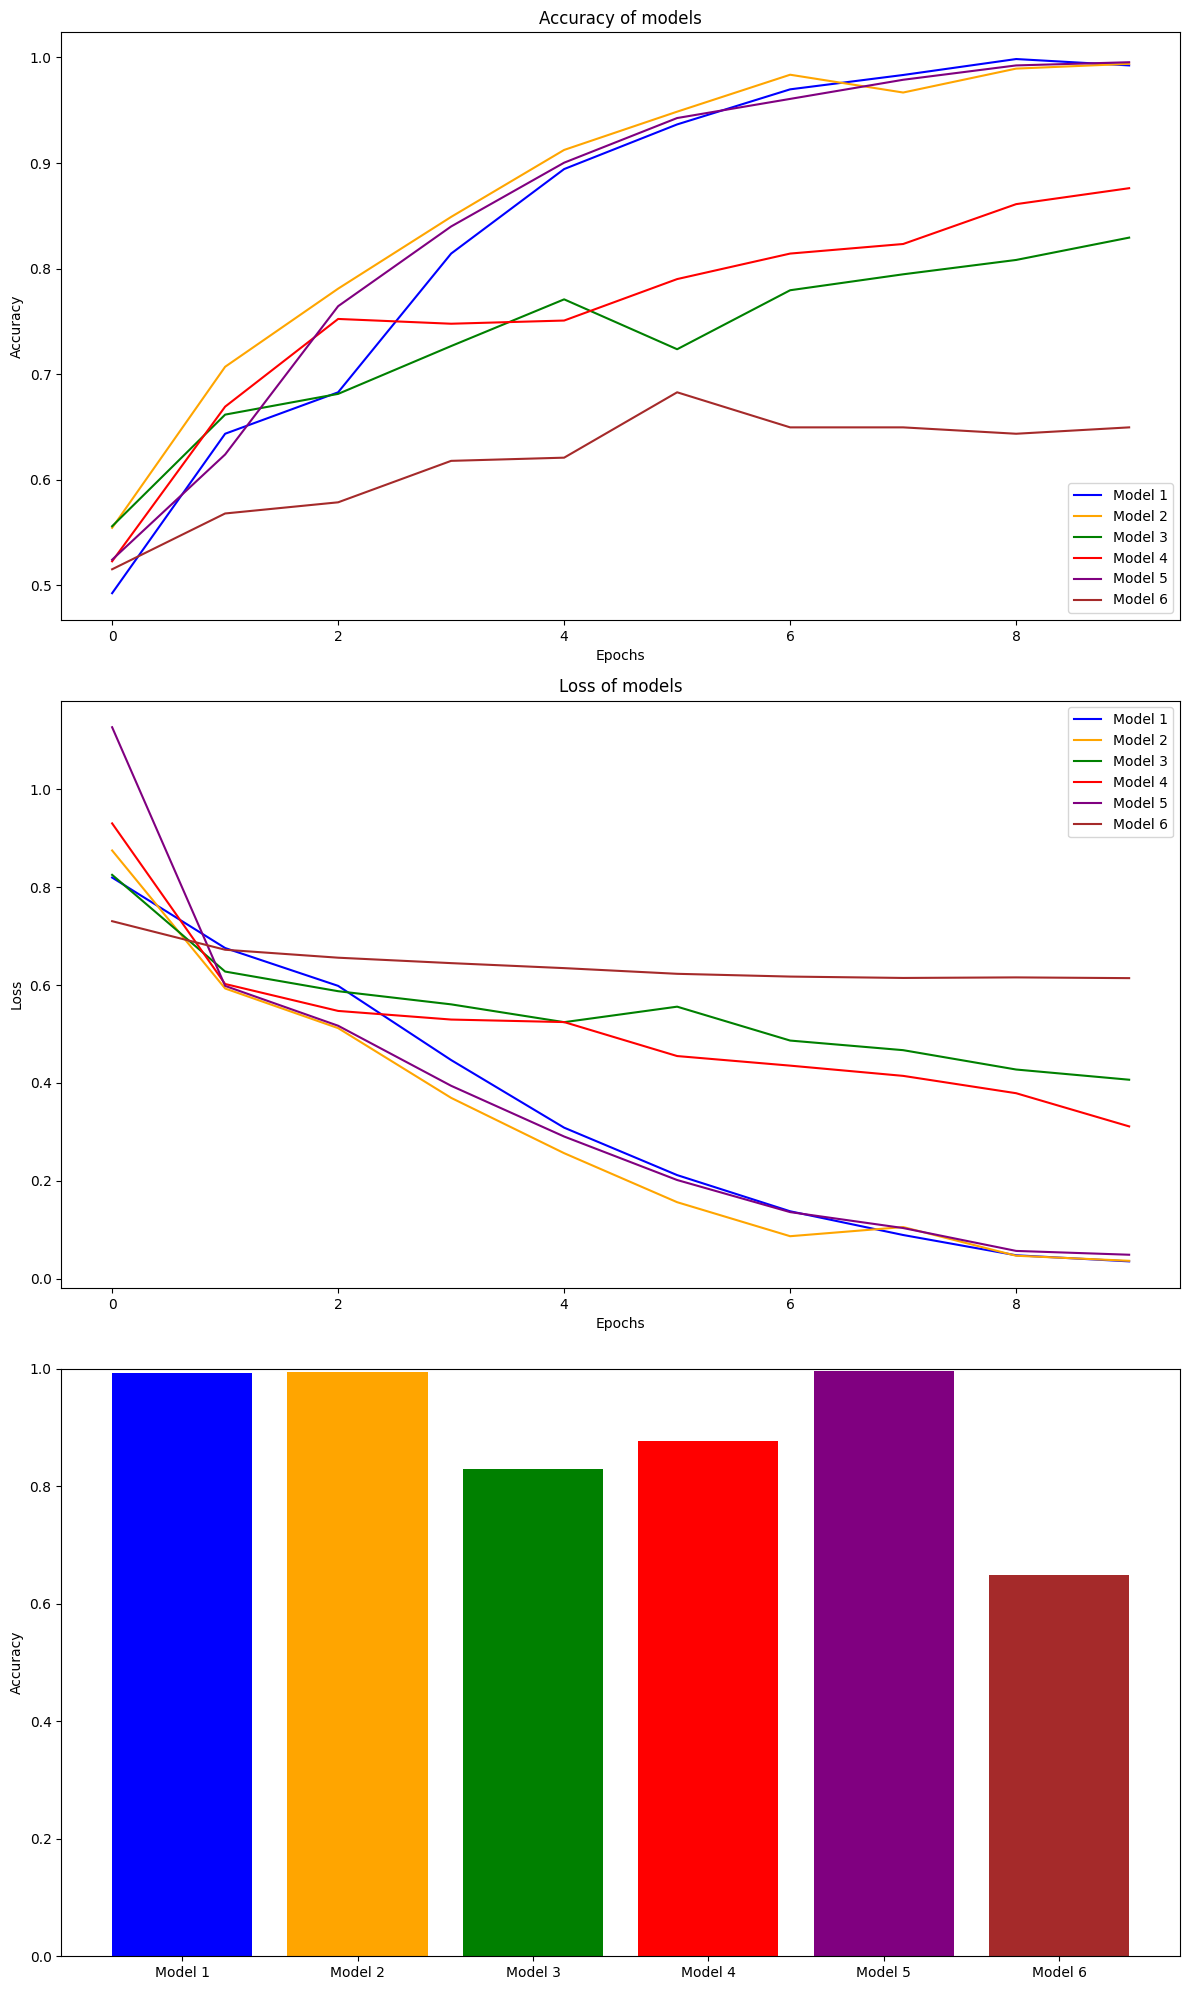

In [ ]:
history_model_1 = history_gray.history
history_model_2 = history_rgb.history
history_model_3 = history_rot.history
history_model_4 = history_flip.history
history_model_5 = history_bright.history
history_model_6 = history_RN50.history


accuracy_values = [
    history_model_1['accuracy'][-1],
    history_model_2['accuracy'][-1],
    history_model_3['accuracy'][-1],
    history_model_4['accuracy'][-1],
    history_model_5['accuracy'][-1],
    history_model_6['accuracy'][-1]
]

model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

plt.figure(figsize=(12, 20))


plt.subplot(3, 1, 1)
plt.plot(history_model_1['accuracy'], label='Model 1', color='blue')
plt.plot(history_model_2['accuracy'], label='Model 2', color='orange')
plt.plot(history_model_3['accuracy'], label='Model 3', color='green')
plt.plot(history_model_4['accuracy'], label='Model 4', color='red')
plt.plot(history_model_5['accuracy'], label='Model 5', color='purple')
plt.plot(history_model_6['accuracy'], label='Model 6', color='brown')

plt.title('Accuracy of models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(3, 1, 2)
plt.plot(history_model_1['loss'], label='Model 1', color='blue')
plt.plot(history_model_2['loss'], label='Model 2', color='orange')
plt.plot(history_model_3['loss'], label='Model 3', color='green')
plt.plot(history_model_4['loss'], label='Model 4', color='red')
plt.plot(history_model_5['loss'], label='Model 5', color='purple')
plt.plot(history_model_6['loss'], label='Model 6', color='brown')

plt.title('Loss of models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.subplot(3, 1, 3)
plt.bar(model_names, accuracy_values, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])


plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()


##Evaluating the best model

In [ ]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
)

test_gray = test_datagen.flow_from_directory(
    valid_path,
    batch_size=batch_size,
    target_size=target_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_loss, test_accuracy = model.evaluate(
    test_gray,
    steps=test_gray.samples // batch_size
)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 200 images belonging to 2 classes.
6/6 [==============================] - 0s 35ms/step - loss: 0.8976 - accuracy: 0.6510
Test Loss: 0.8975794315338135
Test Accuracy: 0.6510416865348816


In [ ]:
model_path = '/content/model.h5'
model.save(model_path)


model.save(model_path)

#Gradio Interface

In [ ]:
def preprocess(image):
    image_array = np.array(image)
    target_size = (224, 224)
    processed_image = tf.image.resize(image_array, target_size)
    processed_image = tf.expand_dims(processed_image, axis=0)
    processed_image = processed_image / 255.0

    return processed_image

model = tf.keras.models.load_model('model.h5')

def predict(image):
    processed_image = preprocess(image)
    predictions = model_2.predict(processed_image)

    class_labels = ["Predator", "Alien"]
    predicted_percentages = [round(percentage * 100, 2) for percentage in predictions[0]]
    results = [f"{label}: {percentage}%" for label, percentage in zip(class_labels, predicted_percentages[::-1])]

    return results

iface = gr.Interface(
    fn=predict,
    inputs="image",
    outputs="text",
    title="Model Prediction",
    description="Model for making predictions."
)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ce1f6ee80e41a388cf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
